In [11]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [12]:
# Transport Parameters

F = 0 # Flow rate (people/day) F=fn
f = 60 # Frequency of trip (/day)
T = 130 # Duration of travel (minutes)
A = 25 * 2.5 * 8 # m^2

In [13]:
# Disease Parameters

beta = 0.6 # Infection rate - probability of infection given contact
c = 0.6 # Infection rate on the coach as a function of T
sigma = 1/2 # Incubation rate - rate at which exposed hosts become infected
gamma = 1/10 # Recovery rate - rate at which infected hosts recover
R = 2 # Longest distance that a large droplet can travel (m)

In [14]:
params = {"infection_rate": beta, "transport_infection_rate": c, "incubation_rate": sigma, "recovery_rate": gamma, "infection_radius": R, "flow" : F, "frequency" : f, "duration" : T, "area" : A}

In [15]:
# Initial Demographic Values

N_A = 10000000
N_B = 10000000

E_A = 0
E_B = 0

I_A = 0.05 * N_A
I_B = 0

R_A = 0
R_B = 0

S_A = N_A - I_A - E_A - R_A
S_B = N_B - I_B - E_B - R_B

In [16]:
# SEIR compartments during travel
def departures(x, n, params=params):
    F = params["flow"]
    delta = (x/n) * F
    return delta


def sei_trans(s, i, params=params):
    F = params["flow"]
    f = params["frequency"]
    R = params["infection_radius"]
    A = params["area"]
    c = params["transport_infection_rate"]
    n = F/f
    delta = (np.pi * np.power(R, 2) * i * s * c)/A
    return delta

In [17]:
# SEIR model
def deriv_seir(sa, ea, ia, ra, sb, eb, ib, rb, params=params):
    F = params["flow"]
    f = params["frequency"]
    A = params["area"]
    beta = params["infection_rate"]
    c = params["transport_infection_rate"]
    sigma = params["incubation_rate"]
    gamma = params["recovery_rate"]
    R = params["infection_radius"]

    na = sa + ia + ea + ra
    nb = sb + ib + eb + rb

    dsa = - (beta * sa * ia)/na - departures(sa, na)
    dea = (beta * sa * ia)/na - sigma * ea - departures(ea, na)
    dia = sigma * ea - gamma * ia - departures(ia, na)
    dra = gamma * ia - departures(ra, na)

    S = departures(sa,na)
    I = departures(ia,na)
    delta = sei_trans(S, I)

    dsb = - (beta * sb * ib)/nb + departures(sa, na) - delta
    deb = (beta * sb * ib)/nb - sigma * eb + departures(ea, na) + delta
    dib = sigma * eb - gamma * ib + departures(ia, na)
    drb = gamma * ib + departures(ra, na)
    
    # Change
    sa += dsa
    ea += dea
    ia += dia
    ra += dra

    sb += dsb
    eb += deb
    ib += dib
    rb += drb

    return [sa, ea, ia, ra, sb, eb, ib, rb]

In [18]:
# Iterate
rowlist = []
for i in range(0, 80):
    # Record
    row = {"t": i, "S_A": S_A, "E_A": E_A, "I_A": I_A, "R_A": R_A, "S_B": S_B, "E_B": E_B, "I_B": I_B, "R_B": R_B}
    rowlist.append(row)

    # Change
    vals = deriv_seir(S_A, E_A, I_A, R_A, S_B, E_B, I_B, R_B)
    S_A = vals[0]
    E_A = vals[1]
    I_A = vals[2]
    R_A = vals[3]
    S_B = vals[4]
    E_B = vals[5]
    I_B = vals[6]
    R_B = vals[7]

df = pd.DataFrame(rowlist)
df["N_A"] = df["S_A"] + df["E_A"] + df["I_A"] + df["R_A"]
df["N_B"] = df["S_B"] + df["E_B"] + df["I_B"] + df["R_B"]
print(df)

     t           S_A            E_A            I_A           R_A         S_B  \
0    0  9.500000e+06       0.000000  500000.000000  0.000000e+00  10000000.0   
1    1  9.215000e+06  285000.000000  450000.000000  5.000000e+04  10000000.0   
2    2  8.966195e+06  391305.000000  547500.000000  9.500000e+04  10000000.0   
3    3  8.671655e+06  490192.005750  688402.500000  1.497500e+05  10000000.0   
4    4  8.313480e+06  603271.362158  864658.252875  2.185902e+05  10000000.0   
..  ..           ...            ...            ...           ...         ...   
75  75  1.268697e+04      30.657945   16103.290792  9.971179e+06  10000000.0   
76  76  1.267471e+04      27.587092   14508.290685  9.972789e+06  10000000.0   
77  77  1.266368e+04      24.826851   13071.255163  9.974240e+06  10000000.0   
78  78  1.265375e+04      22.345237   11776.543072  9.975547e+06  10000000.0   
79  79  1.264481e+04      20.113663   10610.061383  9.976725e+06  10000000.0   

    E_B  I_B  R_B         N_A         N

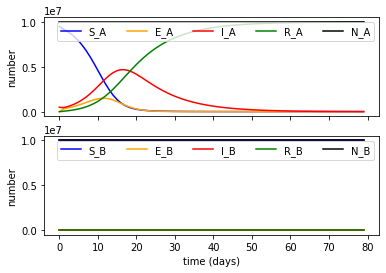

In [19]:
# Plot

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax2.set_xlabel("time (days)")
ax1.set_ylabel("number")
ax2.set_ylabel("number")

ax1.plot(df["t"], df["S_A"], color="blue", label="S_A")
ax1.plot(df["t"], df["E_A"], color="orange", label="E_A")
ax1.plot(df["t"], df["I_A"], color="red", label="I_A")
ax1.plot(df["t"], df["R_A"], color="green", label="R_A")
ax1.plot(df["t"], df["N_A"], color="black", label="N_A")
ax1.legend(loc="upper right", ncol=5)

ax2.plot(df["t"], df["S_B"], color="blue", label="S_B")
ax2.plot(df["t"], df["E_B"], color="orange", label="E_B")
ax2.plot(df["t"], df["I_B"], color="red", label="I_B")
ax2.plot(df["t"], df["R_B"], color="green", label="R_B")
ax2.plot(df["t"], df["N_B"], color="black", label="N_B")
ax2.legend(loc="upper right", ncol=5)

plt.show()
